In [2]:
# Install MNE library (if not already installed)
!pip install mne

# Import necessary libraries
import numpy as np
import scipy.io
import mne
import matplotlib.pyplot as plt
from google.colab import drive



# 1. Mount Google Drive
# Mount Google Drive to access the dataset.
# (Example: drive.mount('/content/drive'))

# 2. Load the Data
# Load the '.mat' file using scipy.io.loadmat.
# (Example: file_path = '/content/drive/My Drive/eea/Dataset/Subject_A_Train.mat'; mat_data = scipy.io.loadmat(file_path))

# 3. Extract & Reshape EEG Signal
# The raw signal is typically 3D (Epochs, Samples, Channels).
# Reshape it into 2D (Channels, Total_Samples) for MNE.
# This involves concatenating epochs and transposing the data.
# Convert the units from microvolts (uV) to Volts (V).

# 4. Process Marker Channels (e.g., Flashing & StimulusCode)
# These markers are usually 3D or 2D and need to be flattened to 1D to match the continuous signal length.
# Ensure the lengths of the processed signal and markers are consistent.

# 5. Construct MNE Events
# Using the processed marker channels (e.g., 'Flashing' for onset detection and 'StimulusCode' for event IDs),
# detect event onsets (e.g., rising edges of the 'Flashing' signal).
# Then, create an MNE-compatible events array: (onset_index, 0, event_id).

# 6. Create MNE Raw Object
# Define the sampling frequency (sfreq), channel names (ch_names), and channel types (ch_types).
# Then, create an MNE 'info' object.
# Finally, create an 'mne.io.RawArray' object from the reshaped EEG signal and the 'info' object.
# Optionally, add the events as a 'stim' channel to the raw object.

In [3]:
#!. mounting google drive
drive.mount('/content/drive')
#2. loading data
file_path = '/content/drive/My Drive/eea_eeg_speller/Subject_A_Train.mat'
mat_data = scipy.io.loadmat(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Signal', 'TargetChar', 'Flashing', 'StimulusCode', 'StimulusType'])

In [5]:
#3. extract and reshape EEG signal
eeg = mat_data['Signal']
epochs, samples, channels = eeg.shape
eeg_continuous = eeg.reshape(epochs*samples, channels)
eeg_continuous = eeg_continuous.T  #now the shape is (channels, total_samples)
eeg_continuous = eeg_continuous*1e-6  #converting microvolts to volts

In [6]:
#4. marker channels
flashing = mat_data['Flashing']
stimulus = mat_data['StimulusType']

flashing_1d = flashing.reshape(-1)  #we convert (epochs, samples) to (epochs*samples)
stimulus_1d = stimulus.reshape(-1)

stim_channel = np.zeros_like(flashing_1d)
stim_channel[flashing_1d == 1] = stimulus_1d[flashing_1d == 1]


stim_channel = stim_channel[np.newaxis, :]


In [7]:
print(eeg_continuous.shape)
print(stim_channel.shape)


(64, 662490)
(1, 662490)


In [8]:
#5. constructing events and 6. creating raw object
data = np.vstack([eeg_continuous, stim_channel])
ch_names = [f'EEG{i+1}' for i in range(eeg_continuous.shape[0])] + ['STI']
ch_types = ['eeg']*eeg_continuous.shape[0] + ['stim']
fs = 240
info = mne.create_info(
    ch_names=ch_names,
    sfreq=fs,
    ch_types=ch_types
)
raw = mne.io.RawArray(data, info)
events = mne.find_events(raw, stim_channel='STI')

Creating RawArray with float64 data, n_channels=65, n_times=662490
    Range : 0 ... 662489 =      0.000 ...  2760.371 secs
Ready.
Finding events on: STI
2550 events found on stim channel STI
Event IDs: [1]


In [9]:
print(events[:10])

[[ 210    0    1]
 [ 378    0    1]
 [ 546    0    1]
 [ 588    0    1]
 [1092    0    1]
 [1134    0    1]
 [1512    0    1]
 [1806    0    1]
 [2058    0    1]
 [2394    0    1]]


In [ ]:
## https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html#

# 1. Visualize Data BEFORE Filtering (Power Spectral Density)
# Compute and plot the Power Spectral Density (PSD) of the raw data
# to observe the frequency content before any filtering (e.g., raw.compute_psd().plot()).

# 2. Apply Band-pass Filter
# Apply a band-pass filter to the raw data (e.g., 0.1Hz - 20Hz) to remove unwanted frequencies.
# Consider using an FIR filter design (e.g., raw.filter(l_freq=..., h_freq=..., fir_design='firwin')).

# 3. Downsample the Data
# Downsample the data to a lower sampling rate (e.g., from 240Hz to 120Hz).
# MNE's resample function automatically handles anti-aliasing (e.g., raw.resample(sfreq=...)).

# 4. Visualize Data AFTER Filtering
# Compute and plot the PSD of the filtered and downsampled data
# to verify the effectiveness of the filtering (e.g., raw.compute_psd().plot()).



Effective window size : 8.533 (s)
Plotting power spectral density (dB=True).


/tmp/ipython-input-4137309006.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()


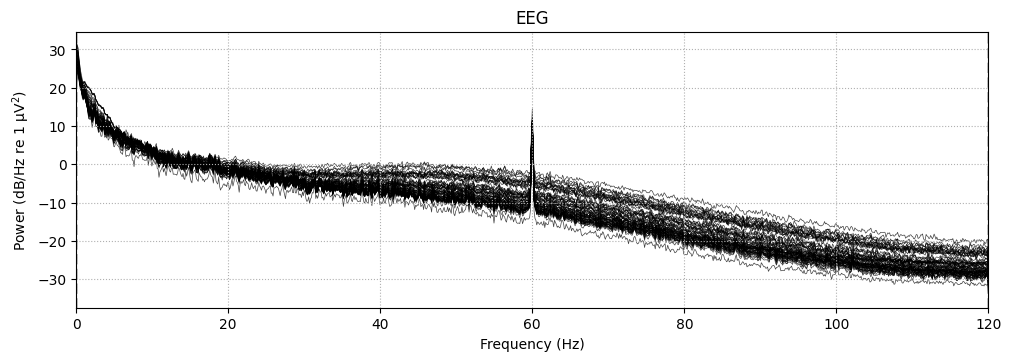

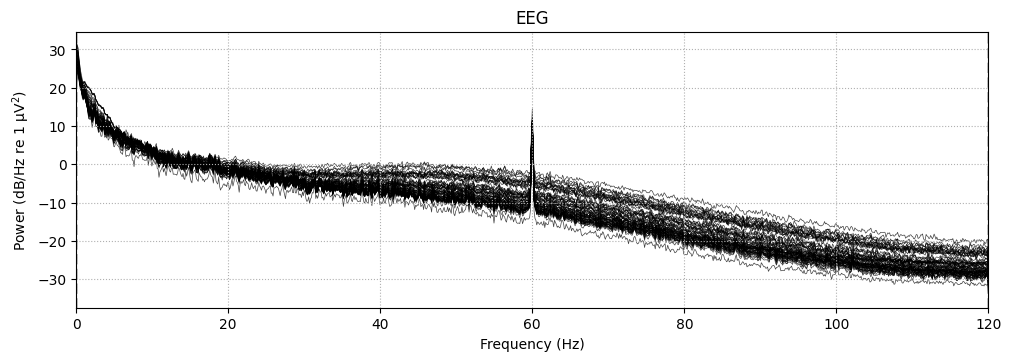

In [10]:
#1. power spectral density (PSD)
raw.compute_psd().plot()

In [11]:
#2. applying band pass filter
raw.filter(
    l_freq=0.1,
    h_freq=20,
    fir_design='firwin'
)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 7921 samples (33.004 s)



<RawArray | 65 x 662490 (2760.4 s), ~328.6 MiB, data loaded>

In [12]:
#3. downsampling the data to 120Hz
raw.resample(120)

Finding events on: STI
2550 events found on stim channel STI
Event IDs: [1]
Finding events on: STI
2550 events found on stim channel STI
Event IDs: [1]


<RawArray | 65 x 331245 (2760.4 s), ~164.3 MiB, data loaded>

Effective window size : 17.067 (s)
Plotting power spectral density (dB=True).


/tmp/ipython-input-1728430222.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()


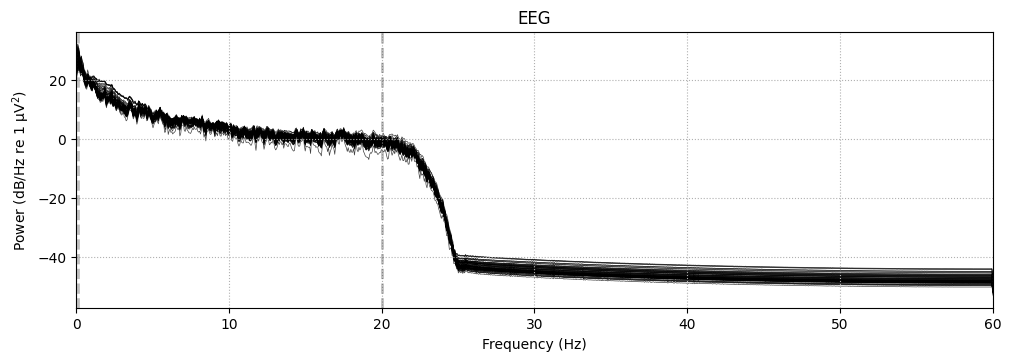

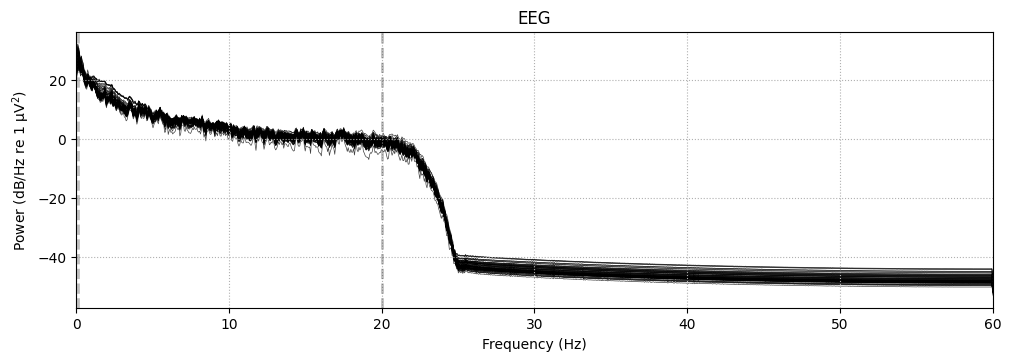

In [13]:
#4. visualising the data
raw.compute_psd().plot()

In [ ]:
# https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#
# 1. Assign Standard Channel Names and Montage
# The initial channel names might be generic (e.g., EEG_1, EEG_2).
# Rename the EEG channels to standard names (e.g., 'FC5', 'Cz', 'Pz')
# that correspond to a known montage (e.g., 'standard_1005' or 'standard_1020').
# This is crucial for visualizing components topologically.
# Then, set a standard montage using mne.channels.make_standard_montage.

# 2. Initialize and Fit ICA
# Initialize an ICA object (e.g., mne.preprocessing.ICA) specifying parameters like n_components and random_state.
# Then, fit the ICA model to the raw data, often applying a high-pass filter (>1Hz) for better component separation.
# (Example: ica.fit(raw, reject=dict(eeg=...)))

# 3. Plot ICA Components
# After fitting, plot the ICA components to visually inspect them for artifacts like eye blinks or muscle activity.
# (Example: ica.plot_components())


In [14]:
#1.
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, match_case=False, on_missing='ignore')

<RawArray | 65 x 331245 (2760.4 s), ~164.3 MiB, data loaded>

In [15]:
#2. initialise and fit ica
ica = mne.preprocessing.ICA(
    n_components=20,
    random_state=97,
    max_iter='auto'
)
ica.fit(raw)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 17.6s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,72 iterations on raw data (331245 samples)
ICA components,20
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=20, n_times=331245
    Range : 0 ... 331244 =      0.000 ...  2760.367 secs
Ready.
Using matplotlib as 2D backend.


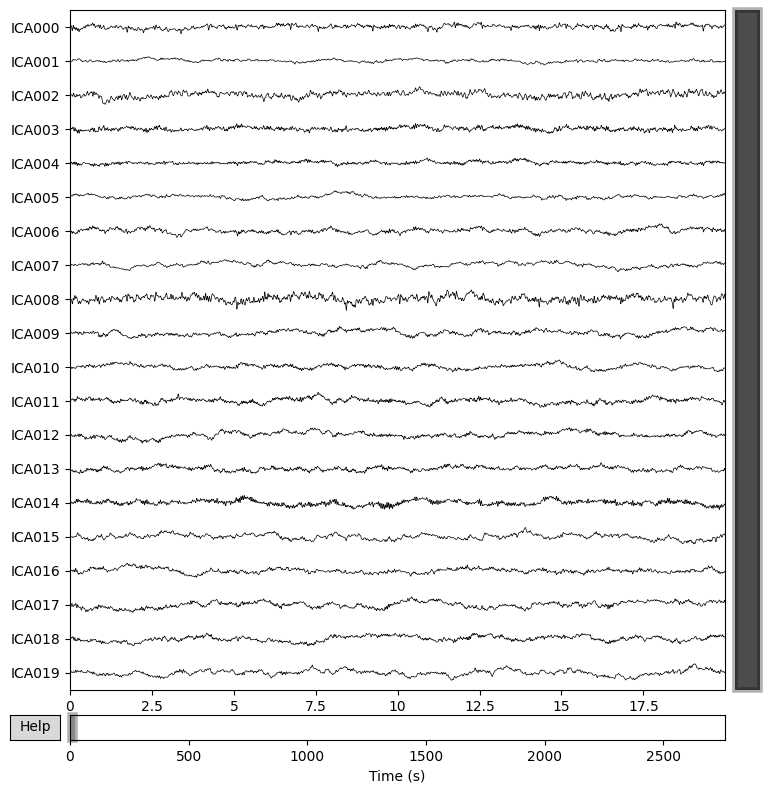

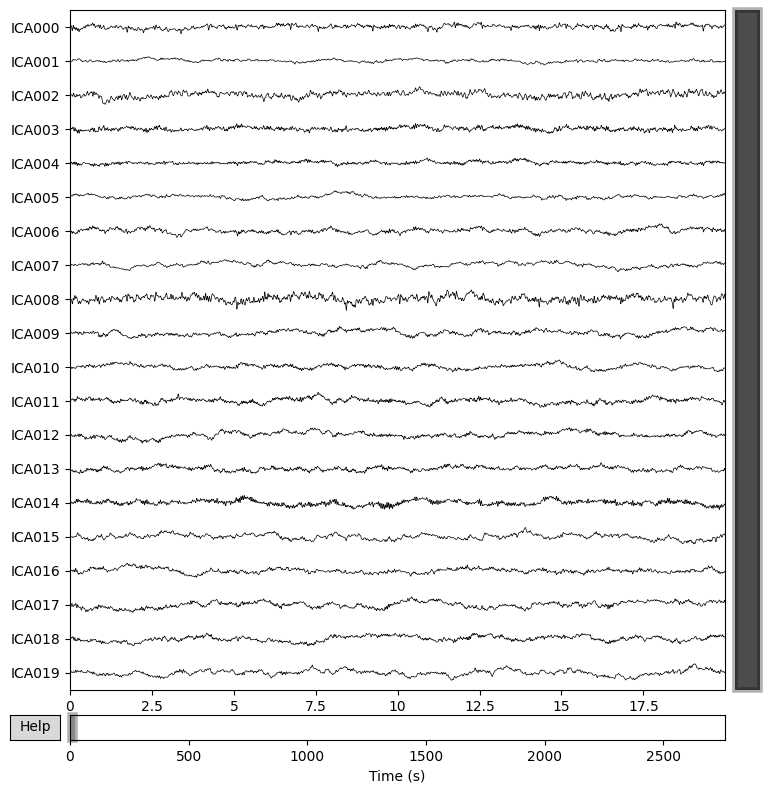

In [16]:
#3. plot
ica.plot_sources(raw)

In [ ]:

# 1. Identify and Exclude Artifact Components
# Based on visual inspection of the ICA components (from the previous step),
# identify components that clearly represent artifacts (e.g., eye blinks, eye movements, muscle activity).
# Then, set the 'exclude' attribute of the ICA object with the indices of these artifact components.

# 2. Apply ICA to Remove Artifacts
# Apply the trained ICA model with the excluded components to the raw data.
# This will project the data back into sensor space with the identified artifact components removed.
# (Example: ica.apply(raw))

# 3. Visualize Clean Data
# To verify the artifact removal, plot a segment of the cleaned raw data.
# Observe if the previously identified artifacts (like large eye blinks) have been successfully suppressed.
# (Example: raw.plot(n_channels=..., duration=..., title='Data AFTER removing Blinks'))


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


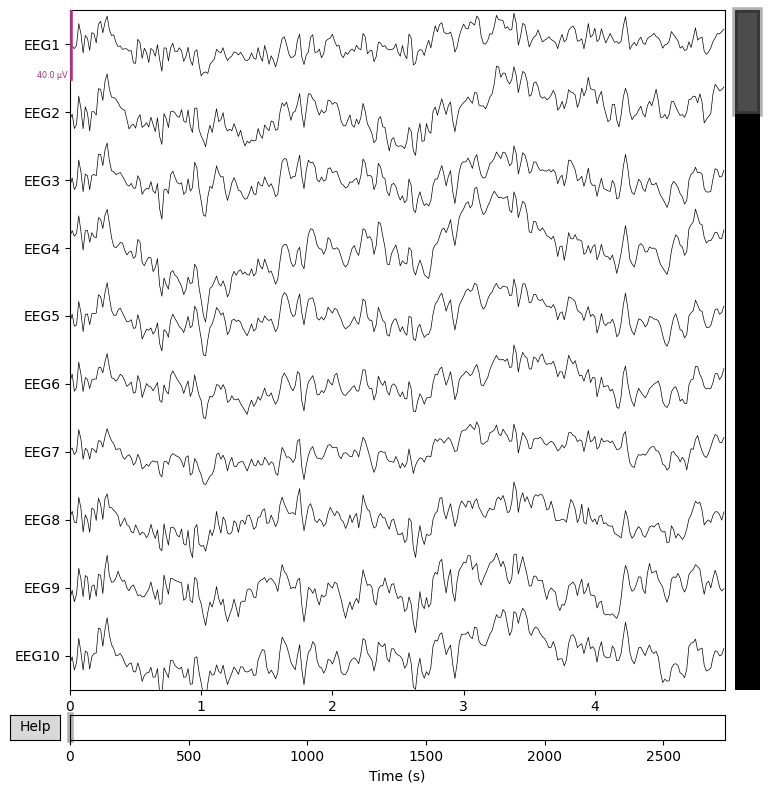

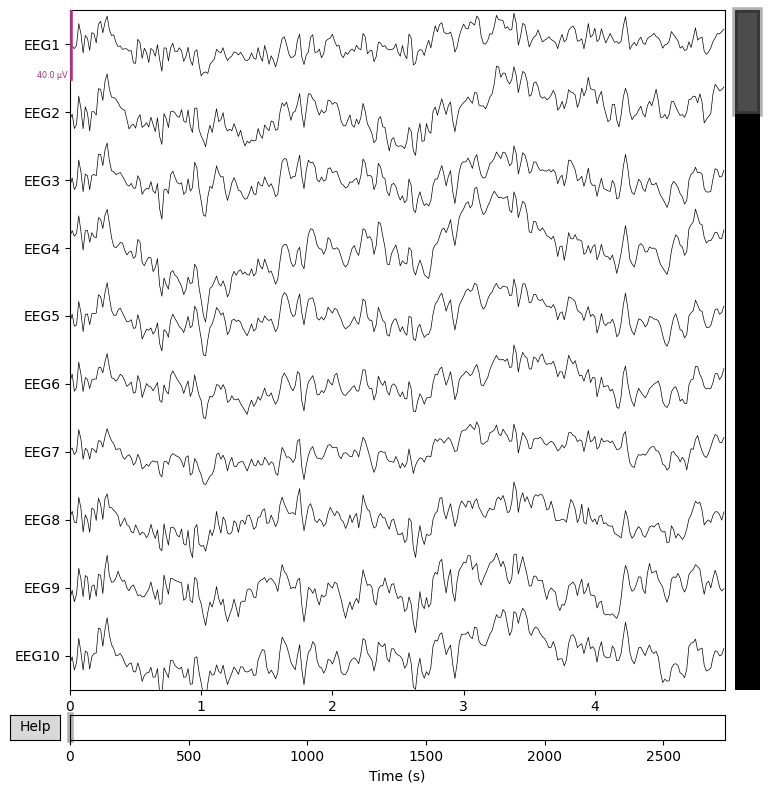

In [17]:
#1.
ica.exclude = [8]   #ICA008 looks noisiest so we exclude that
#2.
ica.apply(raw)
#3.
raw.plot(n_channels=10, duration=5, title='After ICA')

In [ ]:
# 1. Prepare Events for Epoching
# Load and process the 'StimulusType' data to assign labels (e.g., Target/Non-Target)
# to the event onsets identified earlier. Create a new MNE-compatible events array
# where the third column represents the event ID (e.g., 1 for Non-Target, 2 for Target).
# Ensure the event IDs are integers.

# 2. Define Event IDs Dictionary
# Create a dictionary mapping descriptive event names (e.g., 'Non-Target', 'Target') to their corresponding integer IDs.

# 3. Create Epochs
# Use mne.Epochs to segment the continuous raw data around the events.
# Define the epoch time window (e.g., tmin, tmax), set a baseline correction,
# and preload the data into memory.

# 4. Compute Evoked Responses
# Compute the average evoked potentials for each event type (e.g., 'Target' and 'Non-Target')
# using the epochs object.

# 5. Visualize the P300 Response
# Plot the averaged evoked responses, typically focusing on a central parietal electrode like 'Cz' or 'Pz',
# to look for the characteristic P300 component (a positive deflection around 300ms post-stimulus).
# (Example: mne.viz.plot_compare_evokeds for 'Target' vs 'Non-Target' at 'Cz')



In [18]:
#1. we assign target (1) and non-target (2) labels
print(events.shape)
print(np.unique(events[:, 2]))

(2550, 3)
[1]


In [19]:
#2. event ID dict
events_new = []
for i in range(1, len(flashing_1d)):
    # detect rising edge: 0 → 1
    if flashing_1d[i-1] == 0 and flashing_1d[i] == 1:
        if stimulus_1d[i] == 1:
            events_new.append([i, 0, 2])  # Target
        else:
            events_new.append([i, 0, 1])  # Non-Target

events_new = np.array(events_new)

In [21]:
event_id = {
    'Non-Target': 1,
    'Target': 2
}

In [22]:
#3. creating epochs
epochs = mne.Epochs(
    raw,
    events_new,
    event_id=event_id,
    tmin=-0.2,
    tmax=0.8,
    baseline=(None, 0),
    preload=True
)


Not setting metadata
15299 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15299 events and 121 original time points ...
7649 bad epochs dropped


In [23]:
#4.
evoked_target = epochs['Target'].average()
evoked_nontarget = epochs['Non-Target'].average()

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


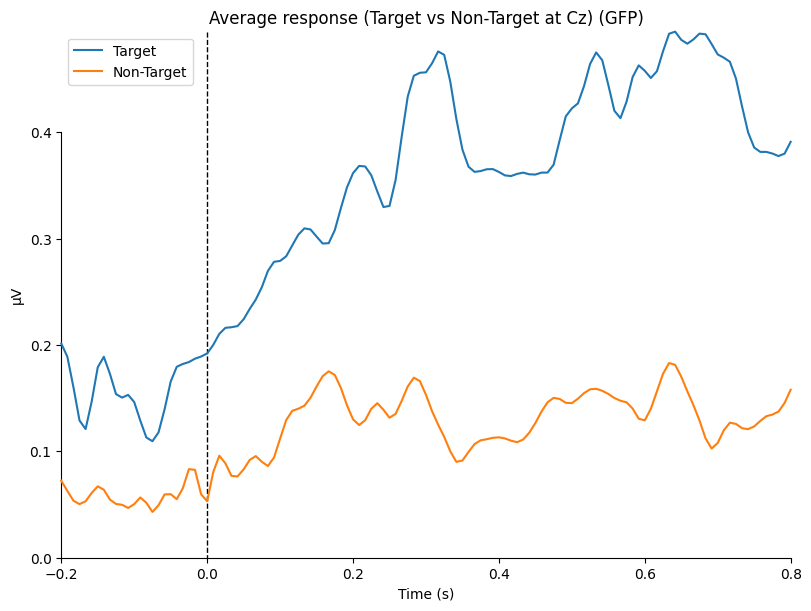

[<Figure size 800x600 with 1 Axes>]

In [28]:
#5. visualising P300 response
#plot at Cz
mne.viz.plot_compare_evokeds(
    {'Target': evoked_target, 'Non-Target': evoked_nontarget},
    picks='eeg',
    title='Average response (Target vs Non-Target at Cz)'
)

In [ ]:

# 1. Compare Evokeds at Pz
# In addition to Cz, plot the evoked responses at channel 'Pz' (Parietal-central)
# as the P300 component is often prominently observed there.
# (Example: mne.viz.plot_compare_evokeds for 'Target' vs 'Non-Target' at 'Pz')



In [29]:
#at Pz
evoked_target = epochs['Target'].average()
evoked_nontarget = epochs['Non-Target'].average()

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


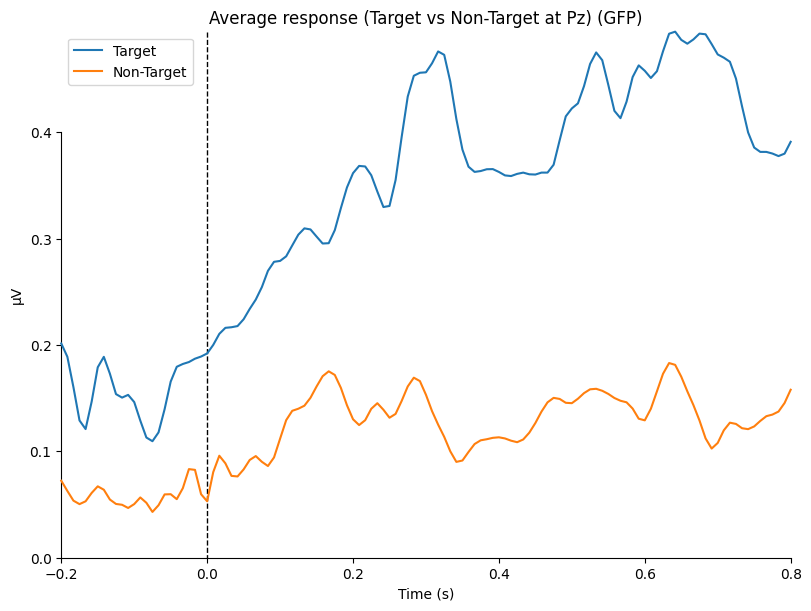

[<Figure size 800x600 with 1 Axes>]

In [31]:
mne.viz.plot_compare_evokeds(
    {'Target': evoked_target, 'Non-Target': evoked_nontarget},
    picks='eeg',
    title='Average response (Target vs Non-Target at Pz)'
)